# Time Series Prediction with Hénon–Heiles Eqaution Inspired Deep Learning ($HPINN$)

AUTHOR: Anurag Dutta (anuragdutta.research@gmail.com)

SUPERVISOR: Tanujit Chakraborty (tanujit.chakraborty@sorbonne.ae)

CREATED: 2023-03-12 18:37:55

## Gathering Dependencies

_Importing Required Libraries_

In [11]:
pip install hampel

You should consider upgrading via the 'C:\Users\Anurag Dutta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [12]:
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Pretraining

_Henon Heiles Intermittency_

The `henon_heiles_intermittency.dat` is generated from the Runge Kutta Method.

This feeds the model with the dynamics of the Henon Heiles Equations

In [13]:
data = np.genfromtxt('datasets/henon_heiles_intermittency.dat')
training_set = pd.DataFrame(data).reset_index(drop=True)
training_set = training_set.iloc[:,1]

## Computing the Gradients

_Calculating the value of_ $\frac{dx}{dt}$, _and_ $\frac{d^2x}{dt^2}$

In [14]:
t_diff = 1 # Daily Data
print(training_set.max())
gradient_t = (training_set.diff()/t_diff).iloc[1:]
print(gradient_t)
gradient_tt = (gradient_t.diff()/t_diff).iloc[1:]
print(gradient_tt)

0.099
1        -0.000989
2        -0.000979
3        -0.000968
4        -0.000958
5        -0.000947
            ...   
139867    0.000000
139868    0.000000
139869    0.000000
139870    0.000000
139871    0.000000
Name: 1, Length: 139871, dtype: float64
2         0.000011
3         0.000010
4         0.000010
5         0.000010
6         0.000010
            ...   
139867    0.000000
139868    0.000000
139869    0.000000
139870    0.000000
139871    0.000000
Name: 1, Length: 139870, dtype: float64


## Loading Datasets

_TURKEY EARTHQUAKE_

In [15]:
data = pd.read_csv("datasets/eq.csv")
training_set = data.iloc[:, 4]
print(training_set)

0       4.4
1       5.2
2       4.8
3       4.4
4       5.7
       ... 
6569    4.5
6570    4.0
6571    4.4
6572    4.1
6573    4.0
Name: Magnitude, Length: 6574, dtype: float64


In [16]:
training_set = training_set.reset_index(drop=True)
gradient_t = gradient_t.reset_index(drop=True)
gradient_tt = gradient_tt.reset_index(drop=True)
print(gradient_t)
print(gradient_tt)

0        -0.000989
1        -0.000979
2        -0.000968
3        -0.000958
4        -0.000947
            ...   
139866    0.000000
139867    0.000000
139868    0.000000
139869    0.000000
139870    0.000000
Name: 1, Length: 139871, dtype: float64
0         0.000011
1         0.000010
2         0.000010
3         0.000010
4         0.000010
            ...   
139865    0.000000
139866    0.000000
139867    0.000000
139868    0.000000
139869    0.000000
Name: 1, Length: 139870, dtype: float64


In [17]:
print(gradient_t.shape)
print(training_set.shape[:-1])
df = pd.concat((training_set[:-1], gradient_t), axis=1)
gradient_tt.columns = ["grad_tt"]
df = pd.concat((df[:-1], gradient_tt), axis=1)
df.columns = ['y_t', 'grad_t', 'grad_tt']

(139871,)
()


## Preprocessing the Data into Supervised Learning

In [18]:
def Supervised(data, n_in=1):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    cols.append(df)
    names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    sup = pd.concat(cols, axis=1)
    sup.columns = names
    sup.dropna(inplace=True)
    return sup


data = Supervised(df.values, n_in=10)
data.drop(['var2(t-10)', 'var3(t-10)', 'var2(t-9)', 'var3(t-9)', 'var2(t-8)',
           'var3(t-8)', 'var2(t-7)', 'var3(t-7)', 'var2(t-6)', 'var3(t-6)',
           'var2(t-5)', 'var3(t-5)', 'var2(t-4)', 'var3(t-4)', 'var2(t-2)',
           'var3(t-2)', 'var2(t-1)', 'var3(t-1)', 'var2(t-3)', 'var3(t-3)'], axis=1, inplace=True)
print(data.head())
print(data.columns)
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
print(data.shape)
y = data[:, -3:]
x = data[:, :-3]
print(x.shape)


    var1(t-10)  var1(t-9)  var1(t-8)  var1(t-7)  var1(t-6)  var1(t-5)  \
10         4.4        5.2        4.8        4.4        5.7        4.3   
11         5.2        4.8        4.4        5.7        4.3        4.0   
12         4.8        4.4        5.7        4.3        4.0        4.8   
13         4.4        5.7        4.3        4.0        4.8        5.2   
14         5.7        4.3        4.0        4.8        5.2        5.1   

    var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)  var1(t)   var2(t)   var3(t)  
10        4.0        4.8        5.2        5.1      4.7 -0.000889  0.000009  
11        4.8        5.2        5.1        4.7      4.6 -0.000880  0.000009  
12        5.2        5.1        4.7        4.6      4.4 -0.000870  0.000009  
13        5.1        4.7        4.6        4.4      4.7 -0.000861  0.000009  
14        4.7        4.6        4.4        4.7      4.1 -0.000852  0.000009  
Index(['var1(t-10)', 'var1(t-9)', 'var1(t-8)', 'var1(t-7)', 'var1(t-6)',
       'var1(t-5)', 

## Train and Test Split

In [19]:
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size
dataX = np.array(x)
dataY = np.array(y)
trainX = np.array(x[0:train_size])
trainY = np.array(y[0:train_size])
testX = np.array(x[train_size:len(x)])
testY = np.array(y[train_size:len(y)])
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(5250, 1, 10) (5250, 3) (1313, 1, 10) (1313, 3)


## Model ($HPINN$)

In [20]:
model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(3))
model.compile(loss='mean_absolute_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=500, batch_size=64,
                    validation_data=(testX, testY), verbose=2, shuffle=False)

Epoch 1/500
83/83 - 9s - loss: 0.3084 - val_loss: 0.2148 - 9s/epoch - 107ms/step
Epoch 2/500
83/83 - 0s - loss: 0.0948 - val_loss: 0.0587 - 366ms/epoch - 4ms/step
Epoch 3/500
83/83 - 0s - loss: 0.1201 - val_loss: 0.0487 - 364ms/epoch - 4ms/step
Epoch 4/500
83/83 - 0s - loss: 0.0961 - val_loss: 0.0406 - 351ms/epoch - 4ms/step
Epoch 5/500
83/83 - 0s - loss: 0.0765 - val_loss: 0.0323 - 350ms/epoch - 4ms/step
Epoch 6/500
83/83 - 0s - loss: 0.0589 - val_loss: 0.0263 - 348ms/epoch - 4ms/step
Epoch 7/500
83/83 - 0s - loss: 0.0456 - val_loss: 0.0234 - 349ms/epoch - 4ms/step
Epoch 8/500
83/83 - 0s - loss: 0.0418 - val_loss: 0.0221 - 350ms/epoch - 4ms/step
Epoch 9/500
83/83 - 0s - loss: 0.0411 - val_loss: 0.0225 - 365ms/epoch - 4ms/step
Epoch 10/500
83/83 - 0s - loss: 0.0411 - val_loss: 0.0224 - 348ms/epoch - 4ms/step
Epoch 11/500
83/83 - 0s - loss: 0.0408 - val_loss: 0.0222 - 360ms/epoch - 4ms/step
Epoch 12/500
83/83 - 0s - loss: 0.0410 - val_loss: 0.0223 - 354ms/epoch - 4ms/step
Epoch 13/500
8

## Metrics ($HPINN$)

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
yhat = model.predict(testX)
print(yhat.shape)
testX = testX.reshape((testX.shape[0], testX.shape[2]))
print(testX.shape)
inv_yhat = np.concatenate((testX, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat1 = inv_yhat[:, -3:]
inv_yhat = inv_yhat[:, -3]
inv_y = np.concatenate((testX, testY), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y1 = inv_y[:, -3:]
inv_y = inv_y[:, -3]
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

42/42 [==============================] - 1s 3ms/step
(1313, 3)
(1313, 10)
Test RMSE: 0.392
Test MAE: 0.250


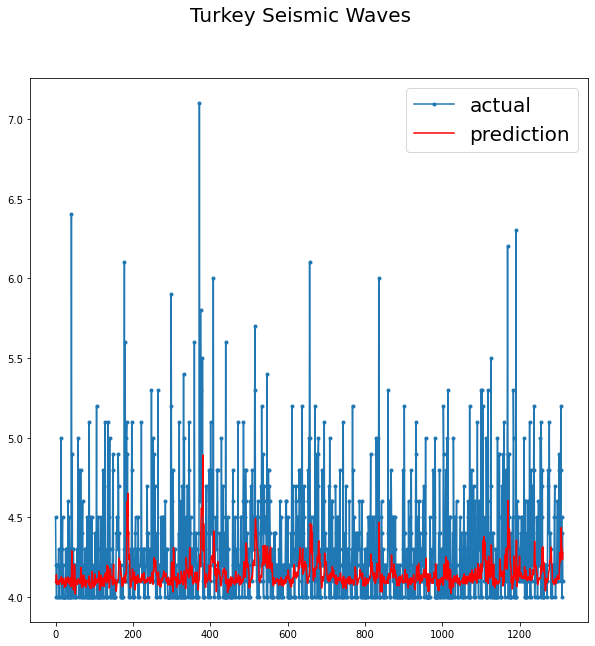

In [22]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
plt.plot(inv_y, marker='.', label="actual")
plt.plot(inv_yhat, 'r', label="prediction")
plt.suptitle('Turkey Seismic Waves', fontsize=20)
plt.legend(fontsize=20)
plt.show()